In [108]:
using Interpolations
using Dierckx
using NPZ
using DifferentialEquations
using Plots
using PyPlot 
import PyPlot
using LaTeXStrings
using QuadGK
using Statistics

In [109]:
filepath = "/net/scratch3/giannis_kx/pixie3d/tests/bonfiglio_div_tok/python_arrays/";

In [110]:
# Reading of arrays
X = npzread(filepath * "X.npy")
Z = npzread(filepath * "Z.npy")
B1 = npzread(filepath * "B1_small2.npy");
B2 = npzread(filepath * "B2_small2.npy");
B3 = npzread(filepath * "B3_small2.npy");

In [111]:
B1t = dropdims(mean(B1,dims=3),dims=3);
B2t = dropdims(mean(B2,dims=3),dims=3);
B3t = dropdims(mean(B3,dims=3),dims=3);

In [112]:
# Performing interpolations
X_int = interpolate(X,(BSpline(Quadratic(Periodic(OnGrid()))),BSpline(Quadratic(Periodic(OnGrid()))),BSpline(Quadratic(Periodic(OnGrid())))));
Z_int = interpolate(Z,(BSpline(Quadratic(Line(OnGrid()))),BSpline(Quadratic(Periodic(OnGrid()))),BSpline(Quadratic(Periodic(OnGrid())))));
B1_int = interpolate(B1t,(BSpline(Quadratic(Line(OnGrid()))),BSpline(Quadratic(Periodic(OnGrid()))),BSpline(Quadratic(Line(OnGrid())))));
B2_int = interpolate(B2t,(BSpline(Quadratic(Line(OnGrid()))),BSpline(Quadratic(Periodic(OnGrid()))),BSpline(Quadratic(Line(OnGrid())))));
B3_int = interpolate(B3t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));

In [113]:
# Interpolation scale
r = range(0.0, length=size(B3)[1], stop=1.0);
u = range(0.0, length=size(B3)[2], stop=2.0*pi);
fi = range(0.0, length=size(B3)[3], stop=2.0*pi);
t = range(0, stop=size(B3)[4]-1);

In [114]:
# Rescaling interpolation intervals
X_sint = scale(X_int, r,u,fi);
Z_sint = scale(Z_int, r,u,fi);
B1_sint = scale(B1_int, r,u,t);
B2_sint = scale(B2_int, r,u,t);
B3_sint = scale(B3_int, r,u,t);

In [115]:
# Extrapolations on rescaled
X_eint = extrapolate(X_sint, Line());
Z_eint = extrapolate(Z_sint, Line());
B1_eint = extrapolate(B1_sint, Line());
B2_eint = extrapolate(B2_sint, Line());
B3_eint = extrapolate(B3_sint, Line());

In [116]:
function CnvNumber2LogicalR(r_num)
    r_dim = size(X,1)
    r_log = r_num/r_dim
    return r_log
end

CnvNumber2LogicalR (generic function with 1 method)

In [117]:
function CnvNumber2LogicalU(u_num)
    u_dim = size(X,2)
    u_log = (2*pi)*u_num/u_dim
    return u_log
end

CnvNumber2LogicalU (generic function with 1 method)

In [118]:
function magnetic_axis(t)
    Bp = sqrt.(B1t.^2 .+ B2t.^2)
    index = argmin(Bp[:,:,t])
    return index[1], index[2]
end

magnetic_axis (generic function with 1 method)

In [119]:
function poloidal_flux(time,r_ind,u_ind)
    r_ma_index, u_ma_index = magnetic_axis(time) # find magnetic axis location
    
    r_ma = CnvNumber2LogicalR(r_ma_index) # Convert magnetic axis index in logical r,theta 
    u_ma = CnvNumber2LogicalU(u_ma_index)
    
    ro = CnvNumber2LogicalR(r_ind) # Convert integration indices to logical r,theta
    uo = CnvNumber2LogicalU(u_ind)
    
    # Integration path is (r_ma,theta_ma)-> (ro,theta_ma)-> (ro,thetao)
    Int1,_ = quadgk(r->B2_eint(r,u_ma,time),r_ma,ro)
    Int2,_ = quadgk(u->B1_eint(ro,u,time),u_ma,uo)
    
    pol_flux = Int1-Int2
    return pol_flux
end

poloidal_flux (generic function with 1 method)

In [120]:
function poloidal_flux2(time,r_ind,u_ind)
    r_ma_index, u_ma_index = magnetic_axis(time) # find magnetic axis location
    
    r_ma = CnvNumber2LogicalR(r_ma_index) # Convert magnetic axis index in logical r,theta 
    u_ma = CnvNumber2LogicalU(u_ma_index)
    
    ro = CnvNumber2LogicalR(r_ind) # Convert integration indices to logical r,theta
    uo = CnvNumber2LogicalU(u_ind)
    
    # Integration path is (r_ma,theta_ma)-> (ro,theta_ma)-> (ro,thetao)
    Int1,_ = quadgk(r->B2_eint(r,u_ma,time)/X_eint(r,u_ma,0),r_ma,ro)
    Int2,_ = quadgk(u->B1_eint(ro,u,time)/X_eint(ro,u,0),u_ma,uo)
    
    pol_flux = X_eint(ro,uo,0)*(Int1-Int2)
    return pol_flux
end

poloidal_flux2 (generic function with 1 method)

In [121]:
function psi(t)
    psi = Float64[]
    r_dim = size(X,1)
    u_dim = size(X,2)
    for r in 1:r_dim
        for u in 1:u_dim
            append!(psi,poloidal_flux2(t,r,u))
        end
    end
    return permutedims(reshape(psi,(u_dim,r_dim)),(2,1))
end

psi (generic function with 1 method)

In [122]:
P = psi(4)

128×65 Array{Float64,2}:
  0.000168142   0.000175757   0.000187031  …   0.000164297   0.000164546
  1.01185e-5    2.22973e-5    4.03499e-5       3.97048e-6    4.36525e-6
 -8.52709e-5   -6.89184e-5   -4.465e-5        -9.35247e-5   -9.29982e-5
 -0.000116549  -9.6382e-5    -6.64188e-5      -0.000126728  -0.00012608
 -8.37833e-5   -6.01125e-5   -2.49451e-5      -9.57241e-5   -9.49615e-5
  1.35433e-5    4.04115e-5    8.03149e-5   …   0.0           8.71259e-7
  0.000175921   0.000205626   0.000249732      0.000160956   0.000161926
  0.000403096   0.000435312   0.000483142      0.000386872   0.000387932
  0.000695461   0.000729972   0.000781194      0.000678085   0.00067923
  0.00105397    0.00109049    0.00114466       0.00103558    0.0010368
  0.00147806    0.00151624    0.00157281   …   0.00145883    0.00146013
  0.00196745    0.00200711    0.00206581       0.00194747    0.00194883
  0.0025237     0.0025647     0.00262529       0.00250304    0.00250447
  ⋮                                  

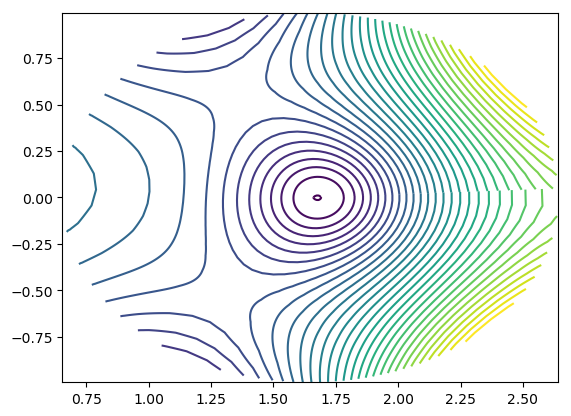

In [123]:
PyPlot.contour(X[:,:,1],Z[:,:,1],P[:,:],30)
PyPlot.show()

In [28]:
function psi_array()
    t_dim = size(B1,4)
    r_dim = size(B1,1)
    u_dim = size(B1,2)
    
    P = Array{Float64}(undef,(r_dim,u_dim,0))
    
    for t in 1:t_dim
        P_temp = psi(t)
        P = cat(dims=3,P,P_temp)
    end
    return P
end

psi_array (generic function with 1 method)

In [29]:
P = psi_array()

128×65×7 Array{Float64,3}:
[:, :, 1] =
  0.000252967   0.00026062   0.000271953  …   0.000249104   0.000249353
  9.31238e-5    0.000105336  0.000123444      8.69598e-5    8.73548e-5
 -2.17735e-6    1.41911e-5   3.84934e-5      -1.0438e-5    -9.9113e-6
 -3.3206e-5    -1.30121e-5   1.70054e-5      -4.34018e-5   -4.27534e-5
  0.0           2.3735e-5    5.9011e-5       -1.19742e-5   -1.12097e-5
  9.77419e-5    0.000124702  0.000164763  …   8.41507e-5    8.50235e-5
  0.000259758   0.000289645  0.000334056      0.0002447     0.000245671
  0.00048581    0.000518444  0.000566938      0.000469371   0.000470435
  0.000776466   0.000811675  0.000863977      0.000758729   0.000759879
  0.00113159    0.00116912   0.00122484       0.00111267    0.0011139
  0.00155021    0.00158991   0.00164882   …   0.0015302     0.0015315
  0.00203293    0.00207482   0.00213692       0.00201181    0.00201318
  0.00258063    0.00262459   0.00268966       0.00255844    0.00255989
  ⋮                                  

In [30]:
size(P)

(128, 65, 7)

In [31]:
npzwrite(filepath * "psi_jul.npy", P)